In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

In [4]:
jtplot.style('default', grid=False)

# Octupole parameters 

In [5]:
r0 = 0.8331 # cm
r0 /= 1e2 # m
omega = 2*np.pi* 1.2e6 # RF frequency Hz
alpha = 0.233 # apex position
q = 0.706 

Dimensionless potential coordinates (for single-charged ion):

$$\alpha = \frac{8 e U}{mr_0^2 \omega^2}$$

$$q = \frac{4 e V_0}{m r_0^2 \omega^2}$$

Where $U$ is the DC voltage and $V_0$ the amplitude of the AC voltage. The total potential at the rods is

 $$ V(-r_0, 0) = V(r_0, 0) = U + V_0 \cos \omega t $$
 $$ V(0, -r_0) = V(0, r_0) = - U - V_0 \cos \omega t $$

# Compute Voltage amplitudes for Ba++  
 - m = 135.9 u
 - Q = + 2 e (double positive charge)

In [6]:
m = 135.904 # u
m *= 1.66e-27 # in kg

Q = 2 * 1.6e-19 # Coulomb

In [7]:
U = m * r0**2 * omega**2 * alpha / (8 * Q)
V0 = m * r0**2 * omega**2 * q / (4 * Q)

U, V0

(81.01637007961851, 490.96615687734476)

## Now check stability parameters for m = 137 u

In [8]:
m1 = 137 * 1.66e-27
alpha1 = 8 * Q * U / (m1 * r0**2 * omega**2)
q1 = 4 * Q * V0 / (m1 * r0**2 * omega**2)
alpha1, q1

(0.23113600000000004, 0.700352)

# Plot trayectories

##  Import output files

In [111]:
def simion_file_metadata(path : str) -> tuple:
    """Retrieve position, name and number of lines of each flight in a simion out file"""
    repet = 0
    skipRows0 = []
    nrows0 = []
    names = []

    with open(path) as infile:
        for i,line in enumerate(infile):
            if '"Ion N","Events","TOF","Mass"' in line:
                repet += 1
                skipRows0.append(i)
                names.append(line[:-1].replace(' ', '_').replace('"', '').split(','))
                
            if ("------ Begin Next Fly'm ------" in line) and (repet > 0) :
                nrows0.append(i - skipRows0[-1] - 2)
            
    return (skipRows0, nrows0, names)

def arrange_ions(df0 : pd.DataFrame) -> list:
    df0.drop(1, axis = 0, inplace=True) # Second row is defective, drop it
    df0.reset_index(inplace=True, drop=True)
    
    mi_ions = pd.MultiIndex.from_arrays([df0.Ion_N, df0.TOF], names=('Ion_N', 'TOF')) # Group each fly by ion and Time Of Flight (TOF)
    mi_ions.to_frame()
    df0.index = mi_ions
    df0.drop(['Ion_N', 'TOF'], axis=1, inplace=True)  # Drop the original columns, leave as multi-index
    
    return df0
    
def import_simion_df(path : str, n_flights : int = 0) -> pd.DataFrame:
    """Import SIMION output flights. 
    Parameters
    -------------
    path : str
        full path to data file. Metadata containing position and length of each flight is automatically read
    n_flights : int = 0
        number of flights to import in file. If unspecified, will import all of them
    
    Returns
    -------------
    List of dataframes for each flight, neatly arranged by ion number
    """
    frames = []
    skipRows0, nrows0, names = simion_file_metadata(path)

    if n_flights > len(skipRows0):
        print('File only contains %i flights, will exit' %len(skipRows0))
        return
    if n_flights == 0:      # If not specified, import all flights
        n_flights = len(skipRows0)
    
    for j, re in enumerate(skipRows0 [: n_flights] ):
        if j < len(skipRows0)-1:
            # Import fly by fly (until nrows0)
            df0 = pd.read_csv(path, skiprows = re, header = 0, nrows = nrows0[j], names=names0[j], engine='python')
            df1 = arrange_ions(df0)
            frames.append(df1)
        else:
            # For last fly import all remaining rows
            df0 = pd.read_csv(path, skiprows = re, header = 0, names=names0[j], engine='python')
            df1 = arrange_ions(df0)
            frames.append(df1)
            
    return frames

In [109]:
path = '/Users/pabloherrero/sabat/simion_cad/0_5grid_cell_size/results/out-1.txt'
dfs = frames = import_simion_df(path, n_flights=12)

In [147]:
dfs[0]

Events     Mass  Charge  E_Instance  M_Instance        X  \
Ion_N TOF                                                                 
2     0             3  135.905     2.0         1.0         0.0  37.2129   
      0.01         66  135.905     2.0         1.0         0.0  37.2129   
      0.02         66  135.905     2.0         1.0         0.0  37.2129   
      0.03         66  135.905     2.0         1.0         0.0  37.2129   
      0.04         66  135.905     2.0         1.0         0.0  37.2129   
      0.05         66  135.905     2.0         1.0         0.0  37.2129   
      0.06         66  135.905     2.0         1.0         0.0  37.2129   
      0.07         66  135.905     2.0         1.0         0.0  37.2129   
      0.08         66  135.905     2.0         1.0         0.0  37.2129   
      0.09         66  135.905     2.0         1.0         0.0  37.2129   
      0.1          66  135.905     2.0         1.0         0.0  37.2129   
      0.11         66  135.905     2.0         1.0         0.0  37.2129   
      0.11125       2  135.905     2.0         1.0         0.0  37.2129   
      0.111875      2  135.905     2.0         1.0         0.0  37.2129   
      0.112187      2  135.905     2.0         1.0         0.0  37.2129   
      0.112227      2  135.905     2.0         1.0         0.0  37.2129   
      0.112236      2  135.905     2.0         1.0         0.0  37.2129   
      0.112237      2  135.905     2.0         1.0         0.0  37.2129   
      0.112237      2  135.905     2.0         1.0         0.0  37.2129   
      0.112237      2  135.905     2.0         1.0         0.0  37.2129   
      0.112237      2  135.905     2.0         1.0         0.0  37.2129   
      0.112238      2  135.905     2.0         1.0         0.0  37.2129   
      0.112238      2  135.905     2.0         1.0         0.0  37.2129   
      0.112238      2  135.905     2.0         1.0         0.0  37.2129   
      0.112238      2  135.905     2.0         1.0         0.0  37.2129   
      0.112239      2  135.905     2.0         1.0         0.0  37.2129   
      0.11224       2  135.905     2.0         1.0         0.0  37.2129   
      0.112243      2  135.905     2.0         1.0         0.0  37.2129   
      0.112249      2  135.905     2.0         1.0         0.0  37.2129   
      0.11226       2  135.905     2.0         1.0         0.0  37.2129   
...               ...      ...     ...         ...         ...      ...   
10    2.97742       2  135.905     2.0         1.0         0.0  37.2712   
      2.98         66  135.905     2.0         1.0         0.0  37.2676   
      2.98516       2  135.905     2.0         1.0         0.0  37.2606   
      2.99         66  135.905     2.0         1.0         0.0  37.2539   
      2.99969       2  135.905     2.0         1.0         0.0  37.2407   
      3            66  135.905     2.0         1.0         0.0  37.2402   
      3.00063       2  135.905     2.0         1.0         0.0  37.2394   
      3.00188       2  135.905     2.0         1.0         0.0  37.2377   
      3.00439       2  135.905     2.0         1.0         0.0  37.2343   
      3.00941       2  135.905     2.0         1.0         0.0  37.2274   
      3.01         66  135.905     2.0         1.0         0.0  37.2266   
      3.01118       2  135.905     2.0         1.0         0.0  37.2250   
      3.01355       2  135.905     2.0         1.0         0.0  37.2218   
      3.01829       2  135.905     2.0         1.0         0.0  37.2154   
      3.02         66  135.905     2.0         1.0         0.0  37.2131   
      3.02341       2  135.905     2.0         1.0         0.0  37.2085   
      3.03         66  135.905     2.0         1.0         0.0  37.1996   
      3.04         66  135.905     2.0         1.0         0.0  37.1862   
      3.05         66  135.905     2.0         1.0         0.0  37.1728   
      3.06         66  135.905     2.0         1.0         0.0  37.1595   
      3.07         66  135.905     2.0  

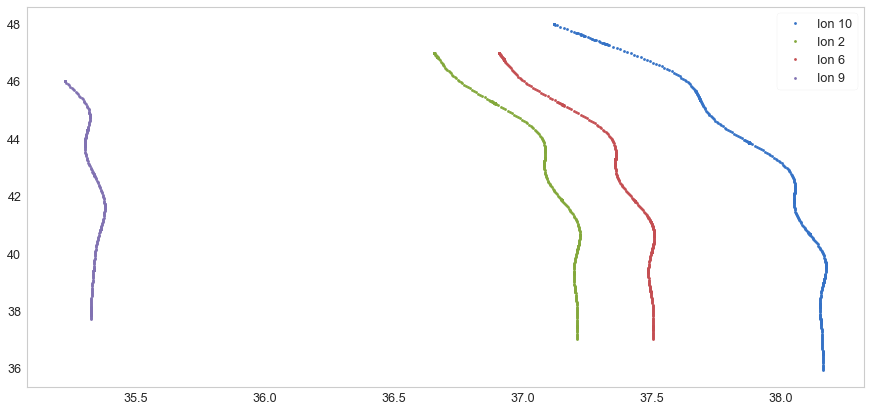

In [157]:
fig, ax = plt.subplots(figsize=(15,7))

for label, df in dfs[0].groupby('Ion_N'):
    ionx = df.X
    iony = df.Y
#     ionz = df.Z
    plt.plot(ionx, iony, '.', label='Ion %s'%label)
plt.legend()
# dfs[0].groupby('Ion_N', )['Vt'].plot(ax=ax)
# .unstack()#.plot(ax=ax)
# data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)
